<a href="https://colab.research.google.com/github/sjkim-audio/guitar-bass-separator/blob/main/notebooks/archive/Exp005_Demucs_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 구글 공유 드라이브에 있는 오디오 파일 다운로드

import gdown
import librosa
from IPython.display import Audio

# 1. 구글 드라이브 공유 링크에서 'FILE_ID' 부분만 추출
# 예: https://drive.google.com/file/d/1A2B3C.../view -> '1A2B3C...'
file_id = '1bjwVU8lThj2E1TDs1rwhZwZTcUgTOASc'

# 2. 다운로드할 URL 구성 & 파일 저장 경로 설정 & 다운로드
url = f'https://drive.google.com/uc?id={file_id}'
output_filename = 'downloaded_audio.wav'
gdown.download(url, output_filename, quiet=False)

# 3. 다운로드한 파일 로드 (48kHz 설정)
# y: 오디오 데이터, sr: 샘플링 레이트 (해당 음원은 48kHz로 렌더링됨)
try:
    y, sr = librosa.load(output_filename, sr=None)
    print(f"샘플링 레이트 {sr}Hz")
    print(f"오디오 길이: {len(y) / sr:.2f}초")
except FileNotFoundError:
    print("파일을 찾을 수 없습니다. 경로를 확인해주세요.")

Audio(data=y, rate=sr)

In [ ]:
# Demucs 라이브러리 설치
!pip install demucs

# Demucs가 분리된 오디오를 저장하는 데 필요한 torchcodec 설치
!pip install torchcodec

In [ ]:
# Demucs를 사용하여 오디오 파일 분리
# 기본 htdemucs 모델은 'vocals', 'drums', 'bass', 'other'로 분리합니다.
# 기타 트랙은 주로 'other' 트랙에 포함될 수 있습니다.

print(f"'{output_filename}' 파일을 Demucs로 분리 중...")

# -n htdemucs: 사용할 모델 지정 (기본 4-stem 모델)
# -d cpu: GPU가 활성화되지 않은 경우 CPU를 사용하도록 설정 (GPU 런타임 시 자동으로 GPU 사용)
!demucs -n htdemucs "{output_filename}"

print("오디오 분리 완료.")

In [ ]:
# 분리된 베이스 트랙 로드 및 재생
import os
from IPython.display import Audio
import librosa

# Demucs 출력 경로 설정 (기본적으로 'separated/htdemucs/<원본_파일_이름_확장자_제외>')
base_name = os.path.splitext(output_filename)[0]
separated_dir = f'separated/htdemucs/{base_name}'

bass_track_path = os.path.join(separated_dir, 'bass.wav')
# 분리된 'other' 트랙 로드 및 재생 (기타 트랙이 여기에 포함될 가능성이 높음)
other_track_path = os.path.join(separated_dir, 'other.wav')

# 트랙 로드 및 재생 함수 정의
def load_and_play_track(track_path):
    if os.path.exists(track_path):
        y, sr = librosa.load(track_path, sr=None)
        print(f"트랙 로드 및 재생: {track_path}")
        print()
        display(Audio(data=y, rate=sr))
    else:
        print(f"오류: 트랙을 찾을 수 없습니다: {track_path}")

load_and_play_track(bass_track_path)
load_and_play_track(other_track_path)

In [ ]:
# 블리딩 확인을 위한 나머지 분리 소스 확인
vocal_track_path = os.path.join(separated_dir, 'vocals.wav')
load_and_play_track(vocal_track_path)

drum_track_path = os.path.join(separated_dir, 'drums.wav')
load_and_play_track(drum_track_path)

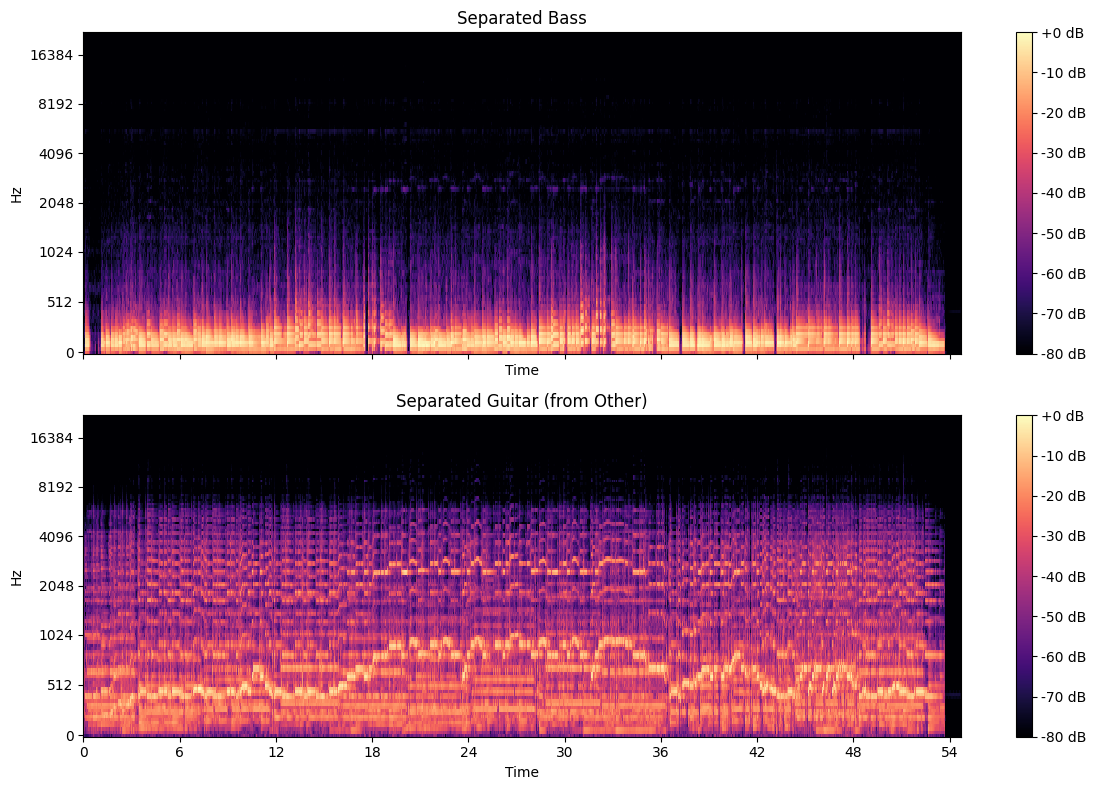

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # numpy import 추가

# 분리된 트랙 시각화
# 시각화를 위한 함수 정의
def plot_mel_spectrogram(y, sr, title, ax):
    # 0. 신호가 스테레오라면 모노로 합침
    if y.ndim > 1:
        y = np.mean(y, axis=0)

    # 1. 멜 스펙트로그램 계산
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

    # 2. dB로 변환
    S_dB = librosa.power_to_db(S, ref=np.max)

    # 3. 그리기
    img = librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', ax=ax)
    ax.set_title(title)
    return img

# 그래프 그리기 설정 (2행 1열)
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 1. 베이스 트랙 시각화
img1 = plot_mel_spectrogram(y_bass, sr_bass, 'Separated Bass', axes[0])
fig.colorbar(img1, ax=axes[0], format='%+2.0f dB')

# 2. 기타 트랙 시각화
img2 = plot_mel_spectrogram(y_other, sr_other, 'Separated Guitar (from Other)', axes[1])
fig.colorbar(img2, ax=axes[1], format='%+2.0f dB')

plt.tight_layout()
plt.show()